In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import matplotlib.pyplot as plt
import copy
import os
import pickle5 as pickle
%matplotlib inline
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")


device

device(type='cuda', index=0)

In [2]:
!pip install pickle5

     |████████████████████████████████| 256 kB 4.3 MB/s 


In [ ]:
!pip install fasttext

     |████████████████████████████████| 68 kB 6.5 MB/s 
  Using cached pybind11-2.9.0-py2.py3-none-any.whl (210 kB)


In [ ]:
import numpy.random as rand
import codecs
import csv
import random
import numpy as np
import numpy.linalg as LA
import fasttext
import copy
import pickle5 as pickle
import os
import torch

'''
The data can be downloaded from https://github.com/t-davidson/hate-speech-and-offensive-language. put the labeled_data.csv in this directory and run this script using python3 process_text_data.py
'''


def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)  

class preprocess_triage_real_data:
    def __init__(self):
        pass

    def process_hate_speech_data(self, src_file, dest_file):

        with open(src_file, 'r') as f:
            f.readline()
            dict_tweet = {}
            response_list = []
            human_annotation_list = []
            while True:
                line_full = f.readline()
                if not line_full:
                    save_data({'tweets': dict_tweet, 'y': response_list, 'y_h': human_annotation_list}, dest_file)
                    return
                else:
                    if line_full.isspace():
                        print('empty')
                    else:
                        line = line_full.split(',', 7)
                        if len(line) == 7:
                            tid = line[0]
                            tweet = line[-1]
                            dict_tweet[tid] = tweet
                            y, y_h = self.get_annotations(line[1:-1])
                            response_list.append(y)
                            human_annotation_list.append(y_h)

    def get_annotations(self, list_of_arg):
        human_response = []
        for i in [1, 2, 3]:
            if int(list_of_arg[i]) > 0:
                human_response.extend([i - 1] * int(list_of_arg[i]))
        response = int(list_of_arg[-1])
        return response, human_response

    def dict_to_txt(self, tweet_dict, file_w):
        with open(file_w, 'w') as f:
            for tweet in tweet_dict.values():
                f.write(tweet)

    def map_range(self, v, l, h, l_new, h_new):
        return float(v - l) * ((h_new - l_new) / float(h - l)) + l_new

    def convert_tweet_to_vector(self, file_dict, file_vec, file_tweet):
        epsilon = 0.01
        data_dict = load_data(file_dict)
        data_vec = {}
        n_data = len(data_dict['y'])
        print(n_data)
        data_vec['y'] = np.array(data_dict['y'])
        data_vec['c'] = np.zeros((n_data,3))
        data_vec['hpred'] = np.zeros(n_data)

        for ind, human_pred, response in zip(range(n_data), data_dict['y_h'], data_vec['y']):

            h0 = float(np.sum([hpred==0 for hpred in human_pred]))
            h1 = float(np.sum([hpred==1 for hpred in human_pred]))
            h2 = float(np.sum([hpred==2 for hpred in human_pred]))
            assert(h0 + h1 + h2 == len(human_pred))
            total_votes = float(len(human_pred))
            cc = np.array([float(h0/total_votes),float(h1/total_votes),float(h2/total_votes)])
            data_vec['c'][ind] = np.array([float(h0/total_votes),float(h1/total_votes),float(h2/total_votes)])
            for i,val in enumerate(data_vec['c'][ind]):
                if val<epsilon:
                    data_vec['c'][ind][i] = epsilon
                    data_vec['c'][ind][np.argmax(data_vec['c'][ind])] -= epsilon

            c = torch.distributions.categorical.Categorical(probs = torch.tensor(cc))
            human = np.random.choice(len(human_pred))
            #human = c.sample().item()
            data_vec['hpred'][ind] = human_pred[human]

        self.dict_to_txt(data_dict['tweets'],file_tweet)
        model = fasttext.train_unsupervised(file_tweet, model='skipgram')
        x = []
        for tid in data_dict['tweets'].keys():
            tweet = data_dict['tweets'][tid].replace('\n', ' ')
            x.append(model.get_sentence_vector(tweet).flatten())
        data_vec['x'] = np.array(x)

        save_data(data_vec, file_vec)

    def truncate_data(self, data_file, data_file_tr):
        data = load_data(data_file)
        n = data['y'].shape[0]
        n_tr = int(n / 4)
        print('x', data['x'].shape)
        print('y', data['y'].shape)
        print('c', data['c'].shape)
        data['x'] = data['x'][:n_tr]
        data['y'] = data['y'][:n_tr]
        data['c'] = data['c'][:n_tr]
        data['hpred'] = data['hpred'][:n_tr]
        print('x', data['x'].shape)
        print('y', data['y'].shape)
        print('c', data['c'].shape)
        save_data(data, data_file_tr)

    def split_data(self, frac, file_data, file_data_split):

        data = load_data(file_data)

        print('x', data['x'].shape)
        print('y', data['y'].shape)
        print('c', data['c'].shape)
        num_data = data['y'].shape[0]
        print(num_data)
        num_train = int(frac * num_data)
        num_test = int((num_data - num_train)/2)
        num_val = num_data - (num_test + num_train)
        indices = np.arange(num_data)
        random.shuffle(indices)
        indices_train = indices[:num_train]
        indices_val = indices[num_train:num_train+num_val]
        indices_test = indices[num_train+num_val:num_train+num_val+num_test]
        data_split = {}
        data_split['X'] = data['x'][indices_train]
        data_split['Y'] = data['y'][indices_train]
        data_split['c'] = data['c'][indices_train]
        data_split['hpred'] = data['hpred'][indices_train]

        val = {}
        val['X'] = data['x'][indices_val]
        val['Y'] = data['y'][indices_val]
        val['c'] = data['c'][indices_val]
        val['hpred'] = data['hpred'][indices_val]
        data_split['val'] = val

        test = {}
        test['X'] = data['x'][indices_test]
        test['Y'] = data['y'][indices_test]
        test['c'] = data['c'][indices_test]
        test['hpred'] = data['hpred'][indices_test]
        data_split['test'] = test
        data_split['dist_mat'] = np.zeros((num_test, num_train))
        save_data(data_split, file_data_split)

    def change_format_hatespeech(self, data_file, dest_file):
        data = load_data(data_file)

        from sklearn.preprocessing import StandardScaler
        scaler = StandardScaler()

        x_train = scaler.fit_transform(data['X'])
        x_val = scaler.transform(data['val']['X'])
        x_test = scaler.transform(data['test']['X'])
        data['X'] = x_train
        data['val']['X'] = x_val
        data['test']['X'] = x_test

        c = {'0.0': np.copy(data['c'])}
        val_c = {'0.0': np.copy(data['val']['c'])}
        test_c = {'0.0': np.copy(data['test']['c'])}
        data['c'] = c
        data['val']['c'] = val_c
        data['test']['c'] = test_c
        save_data(data, dest_file)

def find_human_loss(file_path):
    data = load_data(file_path)
    loss_func = torch.nn.NLLLoss(reduction='none')

    Y = torch.from_numpy(copy.deepcopy(data['Y'])).long()
    hprob = torch.log2(torch.from_numpy(copy.deepcopy(data['c']['0.0'])).float())
    hloss = loss_func(hprob, Y)
    human_prob, _ = torch.max(hprob, axis=1)

    val_Y = torch.from_numpy(copy.deepcopy(data['val']['Y'])).long()
    val_hprob = torch.log2(torch.from_numpy(copy.deepcopy(data['val']['c']['0.0'])).float())
    val_hloss = loss_func(val_hprob, val_Y)
    val_human_prob, _ = torch.max(val_hprob, axis=1)


    test_Y = torch.from_numpy(copy.deepcopy(data['test']['Y'])).long()
    test_hprob = torch.log2(torch.from_numpy(copy.deepcopy(data['test']['c']['0.0'])).float())
    test_hloss = loss_func(test_hprob, test_Y)
    test_human_prob, _ = torch.max(test_hprob, axis=1)

    data['hloss'] = hloss
    data['val']['hloss'] = val_hloss
    data['test']['hloss'] = test_hloss

    data['hprob'] = human_prob
    data['val']['hprob'] = val_human_prob
    data['test']['hprob'] = test_human_prob
    save_data(data,file_path)

def main(path):
    src_file = path + 'labeled_data.csv'
    obj = preprocess_triage_real_data()
    dest_file = path + 'data'
    tweet_file = path + 'tweets.txt'
    vec_file = path + 'data_vectorized'
    vec_full_split_file = path + 'input_full'

    obj.process_hate_speech_data(src_file,dest_file)
    obj.convert_tweet_to_vector(dest_file,vec_file,tweet_file)
    obj.split_data(0.6, vec_file , vec_full_split_file)

    dest_file = path + 'hatespeech_data'
    obj.change_format_hatespeech(vec_full_split_file, dest_file)
    find_human_loss(dest_file)

In [4]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [5]:
path =  "/content/drive/MyDrive/Colab Notebooks/differentiable-learning-under-triage-main/Hatespeech/"

In [ ]:
# main("/content/drive/MyDrive/Colab Notebooks/differentiable-learning-under-triage-main/Hatespeech/")

In [6]:
def load_data(file_name):
    assert(os.path.exists(file_name+'.pkl'))
    with open(file_name + '.pkl', 'rb') as f:
        data = pickle.load(f)
    return data

In [7]:
def save_data(data, file_path):
    with open(file_path + '.pkl','wb') as f:
        pickle.dump(data,f,pickle.HIGHEST_PROTOCOL)

In [ ]:
import random
def set_seed(seed):
		random.seed(seed)
		np.random.seed(seed)
		torch.manual_seed(seed)
		if torch.cuda.is_available():
			torch.cuda.manual_seed(seed)
			torch.cuda.manual_seed_all(seed)

#### The hatespeech data can be found [here](https://github.com/t-davidson/hate-speech-and-offensive-language). Features are extracted from each tweet using [fasttext](https://pypi.org/project/fasttext/). Data is preprocessed in "preprocess_text_data.py" and saved in "hatespeech_data.pkl". Refer to section 6 of the paper for a detailed description of preprocessing and human predictions modeling. In this notebook we only load the data which we previously generated using the "preprocess_text_data.py".

In [8]:
constraints = [0.2,0.4,0.6,0.8]
data_path = '/content/drive/MyDrive/Colab Notebooks/differentiable-learning-under-triage-main/Hatespeech/hatespeech_data'
model_dir = '/content/drive/MyDrive/Colab Notebooks/differentiable-learning-under-triage-main/Hatespeech/models/'
if not os.path.exists(model_dir):
    os.mkdir(model_dir)

#### The CNN architecture that we used for text classification is that of [Kim 2014](https://arxiv.org/abs/1408.5882).

In [ ]:
class CNN(nn.Module):
    def __init__(self, vocab_size, n_filters, filter_sizes, output_dim,
                 dropout):
        super().__init__()
        self.conv_0 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[0]))

        self.conv_1 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[1]))

        self.conv_2 = nn.Conv1d(in_channels=1,
                                out_channels=n_filters,
                                kernel_size=(filter_sizes[2]))

        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)

        self.dropout = nn.Dropout(dropout)

        self.logsoftmax = nn.LogSoftmax(dim=-1)

    def forward(self, text):

        embedded = text.unsqueeze(1)

        conved_0 = F.relu(self.conv_0(embedded).squeeze(2))
        conved_1 = F.relu(self.conv_1(embedded).squeeze(2))
        conved_2 = F.relu(self.conv_2(embedded).squeeze(2))


        pooled_0 = F.max_pool1d(conved_0, conved_0.shape[2]).squeeze(2)
        pooled_1 = F.max_pool1d(conved_1, conved_1.shape[2]).squeeze(2)
        pooled_2 = F.max_pool1d(conved_2, conved_2.shape[2]).squeeze(2)

        cat = self.dropout(torch.cat((pooled_0, pooled_1, pooled_2), dim=1))

        cat = self.fc(cat)
        cat = self.logsoftmax(cat).squeeze()
        return cat

#### The CNN architecture for the [surrogate-based triage](https://arxiv.org/abs/2006.01862)

In [ ]:
class CNN_rej(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
        self.convs_rej = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc_rej = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        self.dropout_rej = nn.Dropout(dropout)
        
        self.softmax = nn.Softmax(dim=-1)

    def forward(self, embedded):
        
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs]
            
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        embedded_rej = embedded.unsqueeze(1)
                
        conved_rej = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs_rej]
                            
        pooled_rej = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat_rej = self.dropout_rej(torch.cat(pooled, dim = 1))

        out_rej = self.fc_rej(cat_rej)
        
        out = self.fc(cat)
        out =  torch.cat((out, out_rej), 1)

        out = self.softmax(out)
        return out

In [ ]:
class CNN_rej_ova(nn.Module):
    def __init__(self, vocab_size, embedding_dim, n_filters, filter_sizes, output_dim, 
                 dropout):
        
        super().__init__()
                        
        self.convs = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc = nn.Linear(len(filter_sizes) * n_filters, output_dim)
        
        self.dropout = nn.Dropout(dropout)
                
        self.convs_rej = nn.ModuleList([
                                    nn.Conv1d(in_channels = 1, 
                                              out_channels = n_filters, 
                                              kernel_size = fs) 
                                    for fs in filter_sizes
                                    ])
        
        self.fc_rej = nn.Linear(len(filter_sizes) * n_filters, 1)
        
        self.dropout_rej = nn.Dropout(dropout)
        
        self.sigmoid = nn.Sigmoid()

    def forward(self, embedded):
        
        embedded = embedded.unsqueeze(1)
        
        conved = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs]
            
                
        pooled = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
        
        
        cat = self.dropout(torch.cat(pooled, dim = 1))
        
        embedded_rej = embedded.unsqueeze(1)
                
        conved_rej = [F.relu(conv(embedded)).squeeze(2) for conv in self.convs_rej]
                            
        pooled_rej = [F.max_pool1d(conv, conv.shape[2]).squeeze(2) for conv in conved]
                
        cat_rej = self.dropout_rej(torch.cat(pooled, dim = 1))

        out_rej = self.fc_rej(cat_rej)
        
        out = self.fc(cat)
        out =  torch.cat((out, out_rej), 1)

        conf = self.sigmoid(out)
        return out, conf

# Our Method :

#### According to the optimal triage policy, the machine only is trained on the points on which the difference between the machine loss and human loss is less than $t_{P,b,m}$ (refer to equation 3 in the paper). This is equivalent to sorting the samples based on the difference of machine loss and human loss and then giving to machine the first $\max(\lceil (1-b) \, |D| \rceil, p)$ samples where $p$ is the number of samples with $\ell(m_{\theta_{t-1}}(x_{[i]}), y_{[i]}) - \ell(h_{[i]}, y_{[i]}) < 0$.

In [ ]:
def find_machine_samples(machine_loss, hloss,constraint):
    
    diff = machine_loss - hloss
    argsorted_diff = torch.clone(torch.argsort(diff))
    num_outsource = int(constraint * machine_loss.shape[0])
    index = -num_outsource

    while (index < -1 and diff[argsorted_diff[index]] <= 0):
        index += 1

    machine_list = argsorted_diff[:index]

    return machine_list

#### Here we train the machine model on its points. In each iteration first, the machine points are found and then the machine model is trained on them. We use early stopping with a patience of 10 epochs based on the performance on the validation set to determine when to stop training.

In [ ]:
def train_triage(seed, data_path,constraint):  
    machine_type = 'Differentiable'
    if seed != '':
      mct = machine_type + '_seed_' + str(seed) + '_'
    else:
      mct = machine_type + '_'
    print('training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    if constraint == 0.2:
        lr = 0.005
    else:
        lr = 0.0002

    optimizer = torch.optim.Adam(mnet.parameters(),lr = lr)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    eps = 1e-4
    max_patience = 10
    patience = 0
    
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_loss_batch = loss_func(machine_scores_batch,Y_batch)
            machine_loss.extend(machine_loss_batch.detach())
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)

            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_loss = loss_func(val_machine_scores,val_Y)
            
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            print('val_loss:',val_loss) 
            
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + mct + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            val_losses.append(val_loss)
        
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
            
        if epoch%5==0:
            fig, ax = plt.subplots()
            plt.title('b = ' + str(constraint) + ' epoch : ' + str(epoch),fontsize=22)
            plt.xlim(-5.5,1.3)
            plt.ylim([-24,8])
            plt.xticks([-5,-2,1],[r'$2^{-5}$',r'$2^{-2}$',r'$2^0$'])
            plt.yticks([-20,-10,1],[r'$2^{-20}$',r'$2^{-10}$',r'$2^{0}$'])
            plt.xlabel(r'Human Loss',fontsize=22)
            plt.ylabel(r'Machine Loss',fontsize=22)
            line = np.linspace(-6.2,1.3,100)
            plt.plot(line,line,'--')
            machine_loss = torch.tensor(machine_loss, device = 'cpu')
            plt.scatter(np.log2(hloss[:len(machine_loss)].cpu().data.numpy()),np.log2(np.array(machine_loss)),alpha=0.3)  
            plt.show()
        
    
        
    plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker='o',label='validation')
    plt.legend()
    plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    plt.xlabel(r'Time Step t',fontsize=22)
    plt.ylabel(r'Machine Loss',fontsize=20)
    plt.show()


In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  print("seed: ", seed)
  if seed != '':
    set_seed(seed)
  for constraint in constraints:
      train_triage(seed, data_path,constraint)

Output hidden; open in https://colab.research.google.com to view.

#### We train the additional model g to approximate difference of machine loss and human loss for unseen samples. The same CNN and the same training procedure is used for training g. Please refer to 

In [ ]:
def train_g(seed, data_path, machine_type,constraint):
    if seed != '':
      mct = machine_type + '_seed_' + str(seed) + '_'
    else:
      mct = machine_type + '_'
    print('started training g using the constraint: ',constraint,' Using machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(copy.deepcopy(data['X'])).float().to(device)
    Y = torch.from_numpy(copy.deepcopy(data['Y'])).long().to(device)
    hloss = data['hloss'].to(device)
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
    if machine_type == 'full':
        mnet.load_state_dict(torch.load(model_dir + 'm_full'))
        
    else:
        mnet.load_state_dict(torch.load(model_dir + 'm_' + mct + str(constraint)))
        
    mnet.eval()
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 50
    
    gnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=2, dropout=0.5).to(device)
    
    g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.008)
    loss_func = torch.nn.NLLLoss(reduction='none')
    

    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        g_train_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hloss_batch = hloss[i * batch_size: (i + 1) * batch_size]
            machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
            machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint)
            g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
            g_optimizer.zero_grad()
            g_loss = loss_func(gnet(X_batch),g_labels)
            g_loss.sum().backward()
            g_optimizer.step()
            g_train_loss += float(g_loss.mean())
        train_losses.append(g_train_loss/num_batches)
        print('g_loss:',g_train_loss/num_batches) 
        
        with torch.no_grad():
            val_machine_loss = loss_func(mnet(val_X),val_Y)
            val_machine_indices = find_machine_samples(val_machine_loss,val_hloss,constraint)
            val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X.shape[0])]).to(device)
            val_loss = loss_func(gnet(val_X),val_glabels)
            val_gloss = float(val_loss.mean())
            val_losses.append(val_gloss)
            print('val_g_loss:',float(val_gloss))
            
            if val_gloss + eps < best_val_loss:
                torch.save(gnet.state_dict(), model_dir + 'g_' + mct + str(constraint))
                best_val_loss = val_gloss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

                
        print('\n')
        
    plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
    plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
    plt.title('train and validation curve of g using b = ' + str(constraint),fontsize=22)
    plt.xlabel('Epoch',fontsize=22)
    plt.ylabel(r'g Loss',fontsize=20)
    plt.legend()
    plt.show()
        

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6936589075873295
val_g_loss: 0.5282137393951416
updated the model


----- epoch: 1 -----
g_loss: 0.5164127182215452
val_g_loss: 0.5275341868400574
updated the model


----- epoch: 2 -----
g_loss: 0.5148179844642679
val_g_loss: 0.4977705776691437
updated the model


----- epoch: 3 -----
g_loss: 0.4831256923886637
val_g_loss: 0.4896608591079712
updated the model


----- epoch: 4 -----
g_loss: 0.47813325204576057
val_g_loss: 0.49771368503570557


----- epoch: 5 -----
g_loss: 0.4700584312280019
val_g_loss: 0.4883723556995392
updated the model


----- epoch: 6 -----
g_loss: 0.4697245766098301
val_g_loss: 0.4810122847557068
updated the model


----- epoch: 7 -----
g_loss: 0.46966804408778745
val_g_loss: 0.48258665204048157


----- epoch: 8 -----
g_loss: 0.4669215328370531
val_g_loss: 0.4850921928882599


----- epoch: 9 -----
g_loss: 0.4674963466823101
val_g_loss: 0.4829494655132

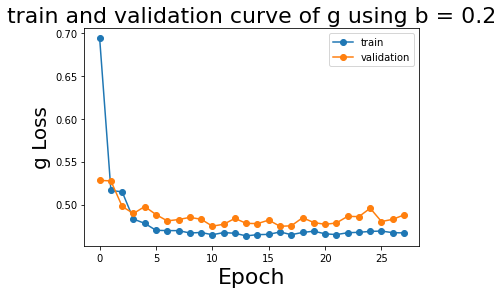

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7211384745314717
val_g_loss: 0.552606463432312
updated the model


----- epoch: 1 -----
g_loss: 0.5464111447023848
val_g_loss: 0.5461142063140869
updated the model


----- epoch: 2 -----
g_loss: 0.5002869484014809
val_g_loss: 0.5073636174201965
updated the model


----- epoch: 3 -----
g_loss: 0.5124418180591116
val_g_loss: 0.5235477685928345


----- epoch: 4 -----
g_loss: 0.47764689195901155
val_g_loss: 0.48314759135246277
updated the model


----- epoch: 5 -----
g_loss: 0.4673511474393308
val_g_loss: 0.48203912377357483
updated the model


----- epoch: 6 -----
g_loss: 0.478055677919959
val_g_loss: 0.5141724348068237


----- epoch: 7 -----
g_loss: 0.46822069957852364
val_g_loss: 0.4845311939716339


----- epoch: 8 -----
g_loss: 0.46905471904513735
val_g_loss: 0.4762500822544098
updated the model


----- epoch: 9 -----
g_loss: 0.47207732995351154
val_g_loss: 0.5199645161628

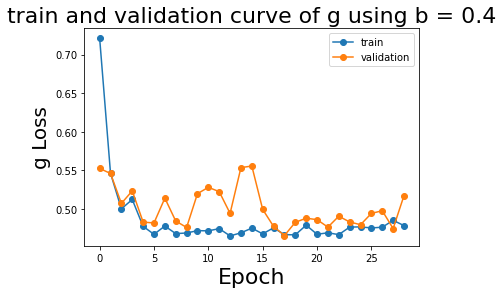

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7623905907385051
val_g_loss: 0.5253723859786987
updated the model


----- epoch: 1 -----
g_loss: 0.5369937061332166
val_g_loss: 0.5833462476730347


----- epoch: 2 -----
g_loss: 0.5232225144281983
val_g_loss: 0.47998547554016113
updated the model


----- epoch: 3 -----
g_loss: 0.5018895516792933
val_g_loss: 0.5232393741607666


----- epoch: 4 -----
g_loss: 0.4743349780328572
val_g_loss: 0.5146181583404541


----- epoch: 5 -----
g_loss: 0.46760600230967003
val_g_loss: 0.49943119287490845


----- epoch: 6 -----
g_loss: 0.4637082686337332
val_g_loss: 0.48215624690055847


----- epoch: 7 -----
g_loss: 0.46926773091157276
val_g_loss: 0.4927961230278015


----- epoch: 8 -----
g_loss: 0.46384208688202005
val_g_loss: 0.47744837403297424
updated the model


----- epoch: 9 -----
g_loss: 0.47629464712614816
val_g_loss: 0.5713847875595093


----- epoch: 10 -----
g_loss: 0.483545654142

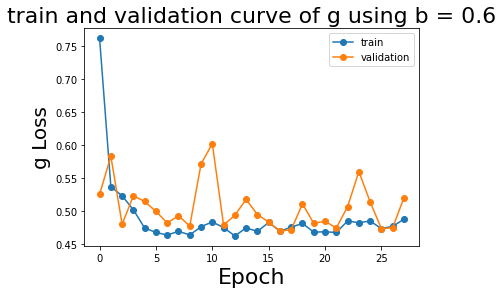

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7595332241617143
val_g_loss: 0.5503596663475037
updated the model


----- epoch: 1 -----
g_loss: 0.5508184038723508
val_g_loss: 0.5971920490264893


----- epoch: 2 -----
g_loss: 0.5211723824807754
val_g_loss: 0.5118072628974915
updated the model


----- epoch: 3 -----
g_loss: 0.4845770405760656
val_g_loss: 0.48272210359573364
updated the model


----- epoch: 4 -----
g_loss: 0.4800474679407974
val_g_loss: 0.5030653476715088


----- epoch: 5 -----
g_loss: 0.47283450157071155
val_g_loss: 0.5538171529769897


----- epoch: 6 -----
g_loss: 0.4656580359830211
val_g_loss: 0.5598316192626953


----- epoch: 7 -----
g_loss: 0.46932597233292955
val_g_loss: 0.47668248414993286
updated the model


----- epoch: 8 -----
g_loss: 0.4692636852463086
val_g_loss: 0.5503191947937012


----- epoch: 9 -----
g_loss: 0.4650917121519645
val_g_loss: 0.4820212423801422


----- epoch: 10 -----
g_loss: 

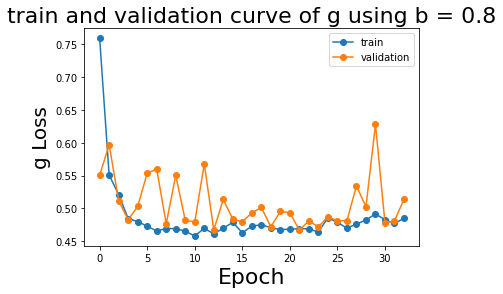

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6999660590663552
val_g_loss: 0.5593594312667847
updated the model


----- epoch: 1 -----
g_loss: 0.5266352701000869
val_g_loss: 0.610945999622345


----- epoch: 2 -----
g_loss: 0.506978900792698
val_g_loss: 0.4979725182056427
updated the model


----- epoch: 3 -----
g_loss: 0.48226360386858386
val_g_loss: 0.485005259513855
updated the model


----- epoch: 4 -----
g_loss: 0.47739129497980076
val_g_loss: 0.4787358343601227
updated the model


----- epoch: 5 -----
g_loss: 0.4738997087503473
val_g_loss: 0.49127113819122314


----- epoch: 6 -----
g_loss: 0.4685004091200729
val_g_loss: 0.4788155257701874


----- epoch: 7 -----
g_loss: 0.47085230440522235
val_g_loss: 0.4853360652923584


----- epoch: 8 -----
g_loss: 0.4684675807754199
val_g_loss: 0.4810391366481781


----- epoch: 9 -----
g_loss: 0.4703028514049947
val_g_loss: 0.4771462380886078
updated the model


----- epoch: 10

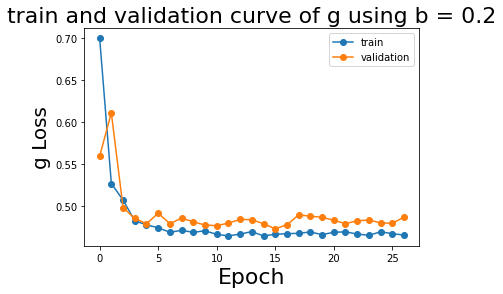

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.756512848349909
val_g_loss: 0.6165259480476379
updated the model


----- epoch: 1 -----
g_loss: 0.5710098440758884
val_g_loss: 0.5703023672103882
updated the model


----- epoch: 2 -----
g_loss: 0.5102618206292391
val_g_loss: 0.5545778274536133
updated the model


----- epoch: 3 -----
g_loss: 0.48422242514789104
val_g_loss: 0.46958494186401367
updated the model


----- epoch: 4 -----
g_loss: 0.4717921883178254
val_g_loss: 0.47547006607055664


----- epoch: 5 -----
g_loss: 0.4762610699205349
val_g_loss: 0.5493955016136169


----- epoch: 6 -----
g_loss: 0.46924745198339224
val_g_loss: 0.4709259569644928


----- epoch: 7 -----
g_loss: 0.47386232134886086
val_g_loss: 0.525115430355072


----- epoch: 8 -----
g_loss: 0.46425567629436654
val_g_loss: 0.48834899067878723


----- epoch: 9 -----
g_loss: 0.46178611057500046
val_g_loss: 0.5187394618988037


----- epoch: 10 -----
g_loss

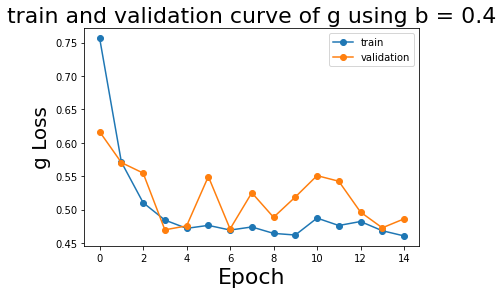

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7763707493431866
val_g_loss: 0.5141497850418091
updated the model


----- epoch: 1 -----
g_loss: 0.5518137752078474
val_g_loss: 0.585051953792572


----- epoch: 2 -----
g_loss: 0.5217571317528685
val_g_loss: 0.5537103414535522


----- epoch: 3 -----
g_loss: 0.49310647292683524
val_g_loss: 0.5100595355033875
updated the model


----- epoch: 4 -----
g_loss: 0.4818056672035406
val_g_loss: 0.5125695466995239


----- epoch: 5 -----
g_loss: 0.469876353473713
val_g_loss: 0.5547393560409546


----- epoch: 6 -----
g_loss: 0.4682889032798509
val_g_loss: 0.47178831696510315
updated the model


----- epoch: 7 -----
g_loss: 0.4793786519827942
val_g_loss: 0.5187761187553406


----- epoch: 8 -----
g_loss: 0.485428507750233
val_g_loss: 0.5288395881652832


----- epoch: 9 -----
g_loss: 0.47055028813580674
val_g_loss: 0.5473173260688782


----- epoch: 10 -----
g_loss: 0.46215388147781294
va

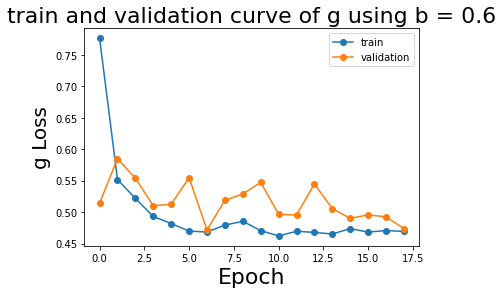

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.72174600760142
val_g_loss: 0.5263632535934448
updated the model


----- epoch: 1 -----
g_loss: 0.5492531714650492
val_g_loss: 0.5123143196105957
updated the model


----- epoch: 2 -----
g_loss: 0.5200912857738634
val_g_loss: 0.48393550515174866
updated the model


----- epoch: 3 -----
g_loss: 0.49317698382462066
val_g_loss: 0.5251756906509399


----- epoch: 4 -----
g_loss: 0.47994570061564445
val_g_loss: 0.49530142545700073


----- epoch: 5 -----
g_loss: 0.48187978014660376
val_g_loss: 0.4907847046852112


----- epoch: 6 -----
g_loss: 0.46681134309619665
val_g_loss: 0.5104970932006836


----- epoch: 7 -----
g_loss: 0.4715155675075948
val_g_loss: 0.5292737483978271


----- epoch: 8 -----
g_loss: 0.4657640236740311
val_g_loss: 0.524806022644043


----- epoch: 9 -----
g_loss: 0.47732617519795895
val_g_loss: 0.504140317440033


----- epoch: 10 -----
g_loss: 0.4687595780317982


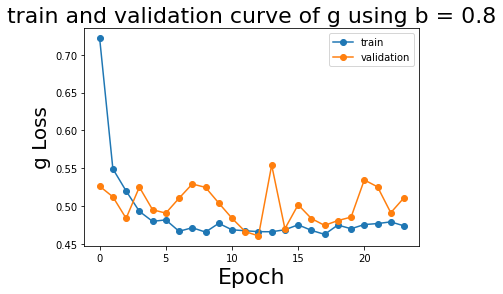

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7339736831684908
val_g_loss: 0.6399335265159607
updated the model


----- epoch: 1 -----
g_loss: 0.513453496620059
val_g_loss: 0.5739487409591675
updated the model


----- epoch: 2 -----
g_loss: 0.4932159303377072
val_g_loss: 0.5126720666885376
updated the model


----- epoch: 3 -----
g_loss: 0.4872229481115937
val_g_loss: 0.4848937690258026
updated the model


----- epoch: 4 -----
g_loss: 0.4684640757429103
val_g_loss: 0.48407483100891113
updated the model


----- epoch: 5 -----
g_loss: 0.46784835308790207
val_g_loss: 0.49760088324546814


----- epoch: 6 -----
g_loss: 0.45867294585332274
val_g_loss: 0.482738196849823
updated the model


----- epoch: 7 -----
g_loss: 0.4610462582980593
val_g_loss: 0.4830462634563446


----- epoch: 8 -----
g_loss: 0.4600513707846403
val_g_loss: 0.49610209465026855


----- epoch: 9 -----
g_loss: 0.46183707580591243
val_g_loss: 0.4795910418033

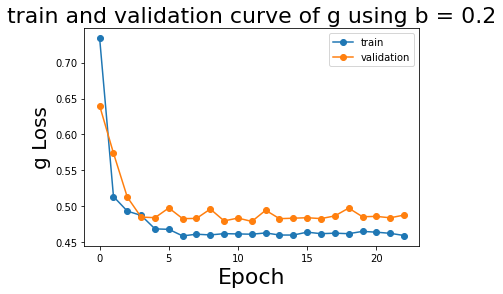

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7461840151809156
val_g_loss: 0.5223492383956909
updated the model


----- epoch: 1 -----
g_loss: 0.5533785815350711
val_g_loss: 0.5847517848014832


----- epoch: 2 -----
g_loss: 0.5168264217985173
val_g_loss: 0.48738786578178406
updated the model


----- epoch: 3 -----
g_loss: 0.49344323653106886
val_g_loss: 0.5392341017723083


----- epoch: 4 -----
g_loss: 0.4787251806507508
val_g_loss: 0.5445665121078491


----- epoch: 5 -----
g_loss: 0.4848432089202106
val_g_loss: 0.4982808828353882


----- epoch: 6 -----
g_loss: 0.46374329443400103
val_g_loss: 0.4694690704345703
updated the model


----- epoch: 7 -----
g_loss: 0.46704617026261985
val_g_loss: 0.5026862025260925


----- epoch: 8 -----
g_loss: 0.4734558667211483
val_g_loss: 0.5334997773170471


----- epoch: 9 -----
g_loss: 0.47071053910379607
val_g_loss: 0.5366783738136292


----- epoch: 10 -----
g_loss: 0.461147771527369

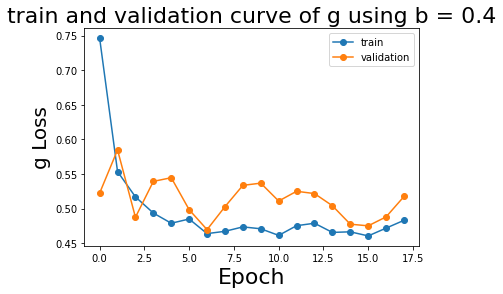

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.746371996589005
val_g_loss: 0.5320883393287659
updated the model


----- epoch: 1 -----
g_loss: 0.5412222989058743
val_g_loss: 0.6438250541687012


----- epoch: 2 -----
g_loss: 0.5195795959637811
val_g_loss: 0.489383339881897
updated the model


----- epoch: 3 -----
g_loss: 0.4889921929376821
val_g_loss: 0.47948330640792847
updated the model


----- epoch: 4 -----
g_loss: 0.47872626556394
val_g_loss: 0.4918939173221588


----- epoch: 5 -----
g_loss: 0.4729741672053933
val_g_loss: 0.5671043992042542


----- epoch: 6 -----
g_loss: 0.46732067433185875
val_g_loss: 0.4846387505531311


----- epoch: 7 -----
g_loss: 0.46292571738983196
val_g_loss: 0.4777933955192566
updated the model


----- epoch: 8 -----
g_loss: 0.47580334606269997
val_g_loss: 0.5118123292922974


----- epoch: 9 -----
g_loss: 0.47323275326440734
val_g_loss: 0.5233647227287292


----- epoch: 10 -----
g_loss: 0.4

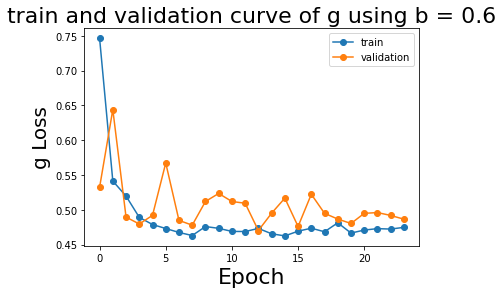

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7496573245152831
val_g_loss: 0.5259644389152527
updated the model


----- epoch: 1 -----
g_loss: 0.5612115993474921
val_g_loss: 0.49276402592658997
updated the model


----- epoch: 2 -----
g_loss: 0.5120583476188282
val_g_loss: 0.49924686551094055


----- epoch: 3 -----
g_loss: 0.4859128917256991
val_g_loss: 0.5210701823234558


----- epoch: 4 -----
g_loss: 0.4744178882489602
val_g_loss: 0.4856792986392975
updated the model


----- epoch: 5 -----
g_loss: 0.4695921077703436
val_g_loss: 0.504658043384552


----- epoch: 6 -----
g_loss: 0.47465964981044334
val_g_loss: 0.5688835978507996


----- epoch: 7 -----
g_loss: 0.47908891225233674
val_g_loss: 0.5365709662437439


----- epoch: 8 -----
g_loss: 0.46854586775104207
val_g_loss: 0.5295405983924866


----- epoch: 9 -----
g_loss: 0.46782241474526626
val_g_loss: 0.47894319891929626
updated the model


----- epoch: 10 -----
g_loss

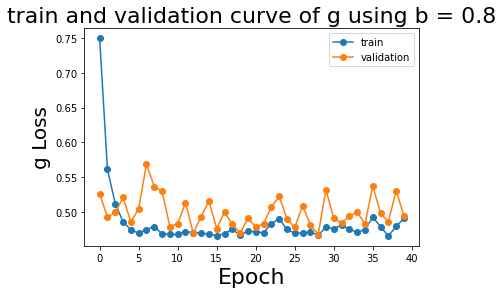

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7795971408486366
val_g_loss: 0.5125214457511902
updated the model


----- epoch: 1 -----
g_loss: 0.510460874841859
val_g_loss: 0.5345664024353027


----- epoch: 2 -----
g_loss: 0.49032130325213075
val_g_loss: 0.511483907699585
updated the model


----- epoch: 3 -----
g_loss: 0.4778562559125324
val_g_loss: 0.5161973834037781


----- epoch: 4 -----
g_loss: 0.4713185961979131
val_g_loss: 0.5401950478553772


----- epoch: 5 -----
g_loss: 0.4684358074640234
val_g_loss: 0.49389755725860596
updated the model


----- epoch: 6 -----
g_loss: 0.464912346098572
val_g_loss: 0.48528993129730225
updated the model


----- epoch: 7 -----
g_loss: 0.4608287165562312
val_g_loss: 0.48510047793388367
updated the model


----- epoch: 8 -----
g_loss: 0.45839998265728354
val_g_loss: 0.4947969913482666


----- epoch: 9 -----
g_loss: 0.46089892586072284
val_g_loss: 0.47379401326179504
updated the mo

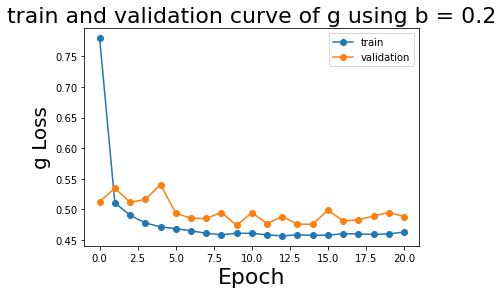

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7319528988252083
val_g_loss: 0.5850734710693359
updated the model


----- epoch: 1 -----
g_loss: 0.5442098549877604
val_g_loss: 0.6080361604690552


----- epoch: 2 -----
g_loss: 0.5197172613504032
val_g_loss: 0.5322940945625305
updated the model


----- epoch: 3 -----
g_loss: 0.47885163966566324
val_g_loss: 0.4881643056869507
updated the model


----- epoch: 4 -----
g_loss: 0.4787739302652578
val_g_loss: 0.509523332118988


----- epoch: 5 -----
g_loss: 0.484038770198822
val_g_loss: 0.5378978848457336


----- epoch: 6 -----
g_loss: 0.4711171907062332
val_g_loss: 0.5434715151786804


----- epoch: 7 -----
g_loss: 0.47315260069444776
val_g_loss: 0.5173770189285278


----- epoch: 8 -----
g_loss: 0.4774205320669959
val_g_loss: 0.5446088910102844


----- epoch: 9 -----
g_loss: 0.4716151057121654
val_g_loss: 0.5672820806503296


----- epoch: 10 -----
g_loss: 0.47617420538639027
va

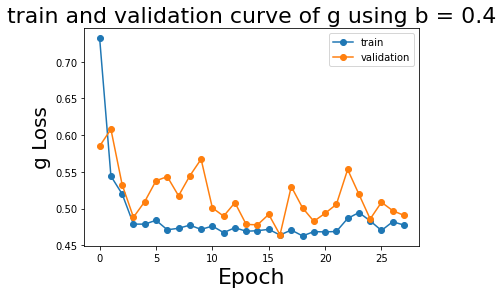

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7466213086930414
val_g_loss: 0.5372446775436401
updated the model


----- epoch: 1 -----
g_loss: 0.5387596435224017
val_g_loss: 0.4994594156742096
updated the model


----- epoch: 2 -----
g_loss: 0.526649507538726
val_g_loss: 0.5074522495269775


----- epoch: 3 -----
g_loss: 0.4914248955901712
val_g_loss: 0.47756657004356384
updated the model


----- epoch: 4 -----
g_loss: 0.4766429158238073
val_g_loss: 0.4909316599369049


----- epoch: 5 -----
g_loss: 0.4705601728831728
val_g_loss: 0.5088620185852051


----- epoch: 6 -----
g_loss: 0.4739281384584804
val_g_loss: 0.564207911491394


----- epoch: 7 -----
g_loss: 0.46847322303801775
val_g_loss: 0.5011988878250122


----- epoch: 8 -----
g_loss: 0.4628349632645647
val_g_loss: 0.4888775050640106


----- epoch: 9 -----
g_loss: 0.470476846365879
val_g_loss: 0.4748246669769287
updated the model


----- epoch: 10 -----
g_loss: 0.481

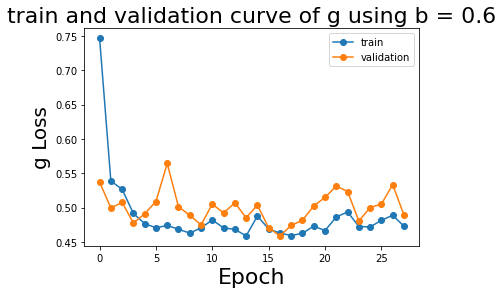

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7180663326289505
val_g_loss: 0.5282778739929199
updated the model


----- epoch: 1 -----
g_loss: 0.5491765821352601
val_g_loss: 0.6135769486427307


----- epoch: 2 -----
g_loss: 0.5055277836509049
val_g_loss: 0.5294820666313171


----- epoch: 3 -----
g_loss: 0.4969864188072582
val_g_loss: 0.5165126919746399
updated the model


----- epoch: 4 -----
g_loss: 0.4740470479397724
val_g_loss: 0.47583314776420593
updated the model


----- epoch: 5 -----
g_loss: 0.4785548478830606
val_g_loss: 0.4825981557369232


----- epoch: 6 -----
g_loss: 0.4683622163720429
val_g_loss: 0.5271602272987366


----- epoch: 7 -----
g_loss: 0.47856532254566747
val_g_loss: 0.5215202569961548


----- epoch: 8 -----
g_loss: 0.46677861191953224
val_g_loss: 0.5496814250946045


----- epoch: 9 -----
g_loss: 0.4699995309735338
val_g_loss: 0.5568772554397583


----- epoch: 10 -----
g_loss: 0.46576139936223626

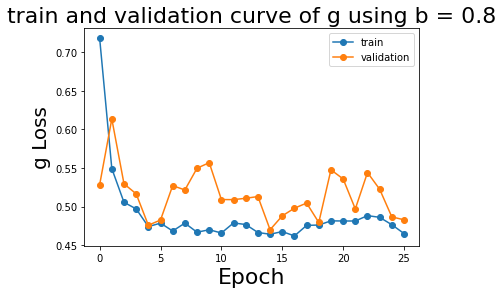

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.6500681430722276
val_g_loss: 0.5525021553039551
updated the model


----- epoch: 1 -----
g_loss: 0.5299857257244488
val_g_loss: 0.5146681070327759
updated the model


----- epoch: 2 -----
g_loss: 0.4959013347203533
val_g_loss: 0.5224980711936951


----- epoch: 3 -----
g_loss: 0.47799182248612243
val_g_loss: 0.49081090092658997
updated the model


----- epoch: 4 -----
g_loss: 0.47065657035758096
val_g_loss: 0.4903496205806732
updated the model


----- epoch: 5 -----
g_loss: 0.4661828647367656
val_g_loss: 0.48158037662506104
updated the model


----- epoch: 6 -----
g_loss: 0.46856503607705235
val_g_loss: 0.49016544222831726


----- epoch: 7 -----
g_loss: 0.46454417969410616
val_g_loss: 0.485949844121933


----- epoch: 8 -----
g_loss: 0.4644190158384542
val_g_loss: 0.475440114736557
updated the model


----- epoch: 9 -----
g_loss: 0.4626593094629546
val_g_loss: 0.471590310335

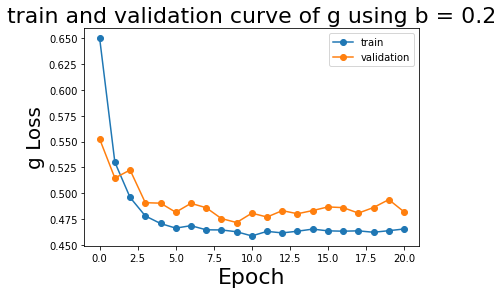

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7717237542383373
val_g_loss: 0.6234514713287354
updated the model


----- epoch: 1 -----
g_loss: 0.5465348980699977
val_g_loss: 0.5651321411132812
updated the model


----- epoch: 2 -----
g_loss: 0.5176460640504956
val_g_loss: 0.49534180760383606
updated the model


----- epoch: 3 -----
g_loss: 0.48143400616633397
val_g_loss: 0.4733726382255554
updated the model


----- epoch: 4 -----
g_loss: 0.47370199284826714
val_g_loss: 0.48377078771591187


----- epoch: 5 -----
g_loss: 0.47152885429871577
val_g_loss: 0.4938395023345947


----- epoch: 6 -----
g_loss: 0.47158368040497106
val_g_loss: 0.49502208828926086


----- epoch: 7 -----
g_loss: 0.4686195694375783
val_g_loss: 0.5278123617172241


----- epoch: 8 -----
g_loss: 0.46646599378436804
val_g_loss: 0.5137425065040588


----- epoch: 9 -----
g_loss: 0.47531379557525116
val_g_loss: 0.5347706079483032


----- epoch: 10 -----
g_l

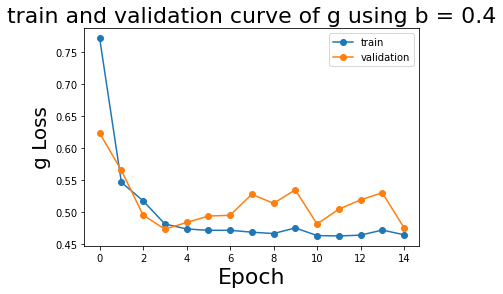

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7146168466036519
val_g_loss: 0.5643178224563599
updated the model


----- epoch: 1 -----
g_loss: 0.5766152148911109
val_g_loss: 0.6601036190986633


----- epoch: 2 -----
g_loss: 0.509831971488893
val_g_loss: 0.4992082417011261
updated the model


----- epoch: 3 -----
g_loss: 0.4879885249150296
val_g_loss: 0.5186253190040588


----- epoch: 4 -----
g_loss: 0.4739935590575139
val_g_loss: 0.4758833050727844
updated the model


----- epoch: 5 -----
g_loss: 0.4725042719704409
val_g_loss: 0.4826962947845459


----- epoch: 6 -----
g_loss: 0.46015822794288397
val_g_loss: 0.49752238392829895


----- epoch: 7 -----
g_loss: 0.46513702006389696
val_g_loss: 0.5061246156692505


----- epoch: 8 -----
g_loss: 0.47171418632691103
val_g_loss: 0.4816405177116394


----- epoch: 9 -----
g_loss: 0.46947638333464664
val_g_loss: 0.4938812553882599


----- epoch: 10 -----
g_loss: 0.4618449485860765

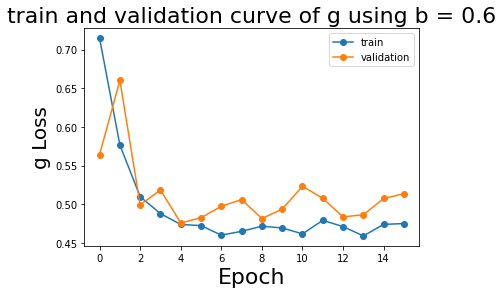

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7608966565070053
val_g_loss: 0.5683398246765137
updated the model


----- epoch: 1 -----
g_loss: 0.5559833565105995
val_g_loss: 0.512045681476593
updated the model


----- epoch: 2 -----
g_loss: 0.5188156417571008
val_g_loss: 0.5062380433082581
updated the model


----- epoch: 3 -----
g_loss: 0.479809843779852
val_g_loss: 0.46803122758865356
updated the model


----- epoch: 4 -----
g_loss: 0.47362855914980173
val_g_loss: 0.4897216856479645


----- epoch: 5 -----
g_loss: 0.4718023502888779
val_g_loss: 0.5189462304115295


----- epoch: 6 -----
g_loss: 0.4687952250242233
val_g_loss: 0.5080929398536682


----- epoch: 7 -----
g_loss: 0.4779310590432336
val_g_loss: 0.5484306216239929


----- epoch: 8 -----
g_loss: 0.4718046283038954
val_g_loss: 0.5411782264709473


----- epoch: 9 -----
g_loss: 0.47478625473255914
val_g_loss: 0.4982008934020996


----- epoch: 10 -----
g_loss: 0.4

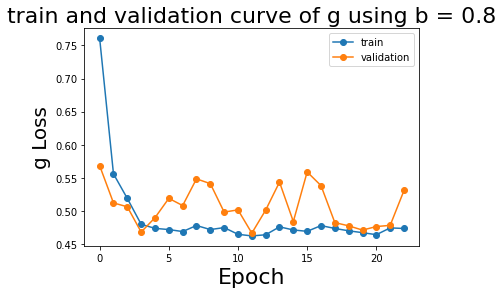

started training g using the constraint:  0.2  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7305285078473389
val_g_loss: 0.5620291233062744
updated the model


----- epoch: 1 -----
g_loss: 0.5098608386081954
val_g_loss: 0.5671615600585938


----- epoch: 2 -----
g_loss: 0.4879508533825477
val_g_loss: 0.5142313838005066
updated the model


----- epoch: 3 -----
g_loss: 0.4778764347235362
val_g_loss: 0.5249497890472412


----- epoch: 4 -----
g_loss: 0.4647514224052429
val_g_loss: 0.5375880002975464


----- epoch: 5 -----
g_loss: 0.4649582904142638
val_g_loss: 0.4972454607486725
updated the model


----- epoch: 6 -----
g_loss: 0.46432264397541684
val_g_loss: 0.4922768771648407
updated the model


----- epoch: 7 -----
g_loss: 0.45809438917785883
val_g_loss: 0.490876704454422
updated the model


----- epoch: 8 -----
g_loss: 0.45874357347687084
val_g_loss: 0.4808347225189209
updated the model


----- epoch: 9 -----
g_loss: 0.4532139597771068
val_g_loss: 0.493375390768051

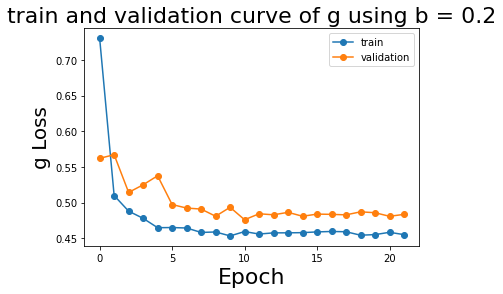

started training g using the constraint:  0.4  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7368327626027167
val_g_loss: 0.6091987490653992
updated the model


----- epoch: 1 -----
g_loss: 0.5413864199072123
val_g_loss: 0.5296765565872192
updated the model


----- epoch: 2 -----
g_loss: 0.52163725408415
val_g_loss: 0.632826566696167


----- epoch: 3 -----
g_loss: 0.4852293396058182
val_g_loss: 0.47597452998161316
updated the model


----- epoch: 4 -----
g_loss: 0.4836204410530627
val_g_loss: 0.4880472719669342


----- epoch: 5 -----
g_loss: 0.4735985305160284
val_g_loss: 0.5026773810386658


----- epoch: 6 -----
g_loss: 0.47606293313826126
val_g_loss: 0.5210567712783813


----- epoch: 7 -----
g_loss: 0.4682722060630719
val_g_loss: 0.4935203790664673


----- epoch: 8 -----
g_loss: 0.4718925746468206
val_g_loss: 0.5563777685165405


----- epoch: 9 -----
g_loss: 0.47179192832360667
val_g_loss: 0.5786622762680054


----- epoch: 10 -----
g_loss: 0.480230253500243
val_

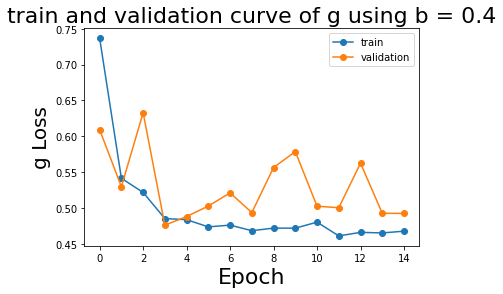

started training g using the constraint:  0.6  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.745843629197528
val_g_loss: 0.5199658274650574
updated the model


----- epoch: 1 -----
g_loss: 0.5556906112469733
val_g_loss: 0.5323935151100159


----- epoch: 2 -----
g_loss: 0.5244350549764931
val_g_loss: 0.537024199962616


----- epoch: 3 -----
g_loss: 0.4767296294060846
val_g_loss: 0.501099169254303
updated the model


----- epoch: 4 -----
g_loss: 0.47037177439779043
val_g_loss: 0.46058475971221924
updated the model


----- epoch: 5 -----
g_loss: 0.48388127563521266
val_g_loss: 0.5958626866340637


----- epoch: 6 -----
g_loss: 0.46791936674465734
val_g_loss: 0.4689386487007141


----- epoch: 7 -----
g_loss: 0.47584911653151113
val_g_loss: 0.5237070322036743


----- epoch: 8 -----
g_loss: 0.47114647133275867
val_g_loss: 0.4993094503879547


----- epoch: 9 -----
g_loss: 0.46384449675679207
val_g_loss: 0.49543890357017517


----- epoch: 10 -----
g_loss: 0.470199304477622

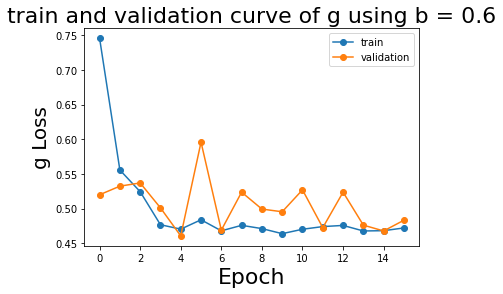

started training g using the constraint:  0.8  Using machine model:  Differentiable
----- epoch: 0 -----
g_loss: 0.7647291038495799
val_g_loss: 0.5367830395698547
updated the model


----- epoch: 1 -----
g_loss: 0.5520026561183234
val_g_loss: 0.5220536589622498
updated the model


----- epoch: 2 -----
g_loss: 0.5147222159430385
val_g_loss: 0.5699735879898071


----- epoch: 3 -----
g_loss: 0.4933049751756092
val_g_loss: 0.581483006477356


----- epoch: 4 -----
g_loss: 0.4832320758141577
val_g_loss: 0.6300325393676758


----- epoch: 5 -----
g_loss: 0.48043526569381356
val_g_loss: 0.568625807762146


----- epoch: 6 -----
g_loss: 0.4910575995842616
val_g_loss: 0.49244004487991333
updated the model


----- epoch: 7 -----
g_loss: 0.4740547987942894
val_g_loss: 0.4961320459842682


----- epoch: 8 -----
g_loss: 0.4813873711973429
val_g_loss: 0.48953917622566223
updated the model


----- epoch: 9 -----
g_loss: 0.4825978633016348
val_g_loss: 0.5114628672599792


----- epoch: 10 -----
g_loss: 0.4

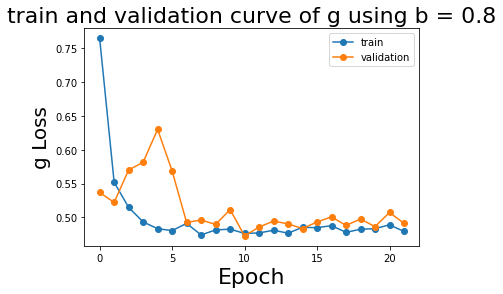

In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  if seed != '':
    set_seed(seed)
  for constraint in constraints:
      train_g(seed, data_path,'Differentiable',constraint)

In [ ]:
def get_test_assignments_us(data_path,constraints):
    l = []
    for seed in ['', 948,  625,  436,  791, 1750]:
      machine_type = 'Differentiable'
      if seed != '':
        mct = machine_type + '_seed_' + str(seed) + '_'
      else:
        mct = machine_type + '_'
      loss_func = torch.nn.NLLLoss(reduction='none')
      data = load_data(data_path)
      test_X = torch.from_numpy(data['test']['X']).float().to(device)
      test_Y = data['test']['Y']
      hlabel = data['test']['hpred']
      
      losses = []
      for constraint in constraints:
          loss = np.zeros(test_X.shape[0])
          num_machine = int((1.0 - constraint) * test_X.shape[0])
          mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=3, dropout=0.5).to(device)

          mnet.load_state_dict(torch.load(model_dir + 'm_' + mct + str(constraint)))
          mnet.eval()
          
          mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
          
          gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=2, dropout=0.5).to(device)

          gnet.load_state_dict(torch.load(model_dir + 'g_' + mct + str(constraint)))
          gnet.eval()
          
          gprediction = torch.exp(gnet(test_X).detach()[:,1])
          to_machine = torch.argsort(gprediction)[:num_machine].cpu().data.numpy()
          to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
          
          mloss = np.not_equal(mlabel,test_Y)
          hloss = np.not_equal(hlabel,test_Y)
          
          loss[to_machine] = mloss[to_machine]
          loss[to_human] = hloss[to_human]

          losses.append(np.mean(loss))
          del mnet
          del gnet
      l.append(losses)
      
    if machine_type not in data.keys():
        data[machine_type] = {}
    l = np.array(l)
    print("l shape: ", l.shape)
    data[machine_type]['agg_loss'] = l
    save_data(data,data_path)

In [ ]:
get_test_assignments_us(data_path,constraints)

l shape:  (6, 4)


In [ ]:
# def boxplot():
#     constraints = [0.4, 0.6, 0.8, 1.0]
#     res = load_data('results/Differentiable')
#     for constraint in constraints:
#         fig, ax = plt.subplots()

#         gpred = res[constraint]['gprediction'].cpu()
#         mloss = res[constraint]['mcrossloss'].cpu()
#         hloss = res[constraint]['hcrossloss'].cpu()
#         to_machine = res[constraint]['to_machine']
#         to_human = res[constraint]['to_human']
#         threshold_map = {0.0: 0.0, 0.2: 0.257, 0.4: 0.257, 0.6: 0.211, 0.8: 0.211, 1.0: 0.373}
#         below = [idx for idx in range(gpred.shape[0]) if idx in to_machine]
#         above = [idx for idx in range(gpred.shape[0]) if idx in to_human]
#         below_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in below]
#         above_data = [np.log2(mloss[idx]) - np.log2(hloss[idx]) for idx in above]
        
#         medianprops = dict(linestyle='-.', linewidth=2.5, color='black')

#         ax1 = ax.boxplot(np.array(below_data), positions=[0],  widths=0.35,sym='',whis=0,medianprops=medianprops,#usermedians=[np.mean(below_data)],
#                          patch_artist=True, boxprops=dict(facecolor="C0"))
#         ax2 = ax.boxplot(np.array(above_data), positions=[1],  widths=0.35,sym='',whis=0,medianprops = medianprops,#usermedians=[np.mean(above_data)],
#                          patch_artist=True, boxprops=dict(facecolor="C1"))
#         plt.show()

In [ ]:
# boxplot()

# Baselines

## [Confidence Based Triage](https://arxiv.org/abs/2004.13102)

In [ ]:
def train_confidence(seed, data_path,constraint):
    machine_type = 'confidence'
    if seed != '':
      mct = machine_type + '_seed_' + str(seed) + '_'
    else:
      mct = machine_type + '_'
    print('-----training machine model using constraint:',constraint,' and machine model: ',machine_type)
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    
        
    optimizer = torch.optim.Adam(mnet.parameters(),lr = 0.0065)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        with torch.no_grad():
            mprim = copy.deepcopy(mnet)
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            hconf_batch = hconf[i * batch_size: (i + 1) * batch_size]
            machine_scores_batch = mprim(X_batch)
            machine_conf_batch, _ = torch.max(machine_scores_batch,axis = 1)   
            machine_indices = find_machine_samples(hconf_batch,machine_conf_batch,constraint)
                
            X_machine = X_batch[machine_indices]
            Y_machine = Y_batch[machine_indices]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_machine),Y_machine)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = 0
            val_machine_scores = mprim(val_X)
            val_machine_conf,_ = torch.max(val_machine_scores,axis=1)

            val_machine_indices = find_machine_samples(val_hconf,val_machine_conf,constraint)

            val_loss = float(loss_func(mnet(val_X[val_machine_indices]),val_Y[val_machine_indices]).mean())
            
            val_losses.append(val_loss)
            print('val_loss:',val_loss) 
            
            if val_loss + eps <best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + mct + str(constraint))
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break
      
        print('\n')
            
    # plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    # plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    # plt.legend()
    # plt.title(machine_type + ' b = ' + str(constraint),fontsize=22)
    # plt.xlabel(r'Time Step t',fontsize=22)
    # plt.ylabel(r'Machine Loss',fontsize=20)
    # plt.show()
        

In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  if seed != '':
    set_seed(seed)
  for constraint in constraints:
    train_confidence(seed, data_path,constraint)

-----training machine model using constraint: 0.2  and machine model:  confidence
----- epoch: 0 -----
machine_loss: 0.9505808811324338
val_loss: 0.6951022744178772
updated the model


----- epoch: 1 -----
machine_loss: 0.6618872164593389
val_loss: 0.6435062885284424
updated the model


----- epoch: 2 -----
machine_loss: 0.6065864701910565
val_loss: 0.6061074733734131
updated the model


----- epoch: 3 -----
machine_loss: 0.5561038886662573
val_loss: 0.7013848423957825


----- epoch: 4 -----
machine_loss: 0.6044461952211956
val_loss: 0.6540109515190125


----- epoch: 5 -----
machine_loss: 0.5311421448520074
val_loss: 0.5251537561416626
updated the model


----- epoch: 6 -----
machine_loss: 0.529906909679994
val_loss: 0.5588690638542175


----- epoch: 7 -----
machine_loss: 0.5674369018524885
val_loss: 0.5819627046585083


----- epoch: 8 -----
machine_loss: 0.5420065041010579
val_loss: 0.5432219505310059


----- epoch: 9 -----
machine_loss: 0.527403883713608
val_loss: 0.5236015319824219


In [ ]:
def get_test_assignments_confidence(data_path,constraints):
    machine_type = 'confidence'
    l = []
    for seed in ['', 948,  625,  436,  791, 1750]:
      if seed != '':
        mct = machine_type + '_seed_' + str(seed) + '_'
      else:
        mct = machine_type + '_'

      loss_func = torch.nn.NLLLoss(reduction='none')
      data = load_data(data_path)
      test_X = torch.from_numpy(data['test']['X']).float().to(device)
      test_Y = data['test']['Y']
      hlabel = data['test']['hpred']
      hconf = (torch.mean(data['hprob']) + torch.zeros(test_X.shape[0])).to(device)
      
      losses = []
      for constraint in constraints:
          mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=3, dropout=0.5).to(device)

          mnet.load_state_dict(torch.load(model_dir + 'm_' + mct + str(constraint)))
          mnet.eval()
          mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
          loss = np.zeros(test_X.shape[0])
          mconf,_ = torch.max(mnet(test_X),axis = 1)
          to_machine = find_machine_samples(hconf,mconf,constraint).cpu().data.numpy()

          to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

          mloss = np.not_equal(mlabel,test_Y)
          hloss = np.not_equal(hlabel,test_Y)

          loss[to_machine] = mloss[to_machine]
          loss[to_human] =  hloss[to_human]

          losses.append(np.mean(loss))
          del mnet
          
      l.append(losses)
    
    if machine_type not in data.keys():
        data[machine_type] = {}

    l = np.array(l)
    print('l shape: ', l.shape)
    data[machine_type]['agg_loss'] = l
    
    save_data(data,data_path)

In [ ]:
get_test_assignments_confidence(data_path,constraints)

l shape:  (6, 4)


## Full Automation Triage
The machine model is trained under full automation and then an additional model g is trained based on the difference of machine and human loss and used to outsource samples at test time.

In [ ]:
def train_full(seed, data_path, machine_type):
    print('-----training machine model: ',machine_type)
    if seed != '':
      mct = machine_type + '_seed_' + str(seed)
    else:
      mct = machine_type 
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).long().to(device)
    hloss = data['hloss'].to(device)
    hconf = torch.mean(data['hprob']) + torch.zeros(X.shape[0]).to(device)
    
    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).long().to(device)
    val_hloss = data['val']['hloss'].to(device)
    val_hconf = torch.mean(data['hprob']) + torch.zeros(val_X.shape[0]).to(device)
    
    batch_size = 64
    num_batches = int(X.shape[0] / batch_size)
    val_num_batches = int(val_X.shape[0]/batch_size)
    
    num_epochs = 30
        
    mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)

    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.005)
    loss_func = torch.nn.NLLLoss(reduction='none')
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4
    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        train_loss = 0
        machine_loss = []
        for i in range(num_batches):
            X_batch = X[i * batch_size: (i + 1) * batch_size]
            Y_batch = Y[i * batch_size: (i + 1) * batch_size]
            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),Y_batch)
            loss.sum().backward()
            optimizer.step()
            train_loss += float(loss.mean())

        train_losses.append(train_loss / num_batches)
        print('machine_loss:', train_loss/num_batches)
        
        with torch.no_grad():
            val_loss = float(loss_func(mnet(val_X),val_Y).mean())
            print('val_loss:',val_loss)
            val_losses.append(val_loss)
            if val_loss + eps < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + mct)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
                
        if patience > max_patience:
            print('no progress for 10 epochs... stopping training')
            break

        print('\n')
    
    
    # plt.plot(range(len(train_losses)),train_losses,marker='o',label='train')
    # plt.plot(range(len(val_losses)),val_losses,marker='o',label = 'validation')
    # plt.legend()
    # plt.title(machine_type, fontsize=22)
    # plt.xlabel(r'Time Step t',fontsize=22)
    # plt.ylabel(r'Machine Loss',fontsize=20)
    # plt.show()
        

In [ ]:
# train_full(data_path,'full')

In [ ]:
# def train_g_full(data_path):
#     machine_type = 'full'
#     print('started training g Using machine model: ',machine_type)
#     data = load_data(data_path)
#     X = torch.from_numpy(data['X']).float()
#     Y = torch.from_numpy(data['Y']).long()
#     hloss = data['hloss']
    
#     with torch.no_grad():
#         mnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=3, dropout=0.5).to(device)

#         mnet.load_state_dict(torch.load(model_dir + 'm_full'))

#         mnet.to(device)
#         mnet.eval()
    
    
#     val_X = torch.from_numpy(data['val']['X']).float()
#     val_Y = torch.from_numpy(data['val']['Y']).long()
#     val_hloss = data['val']['hloss']
    
#     batch_size = 128
#     num_batches = int(X.shape[0] / batch_size)
#     val_num_batches = int(val_X.shape[0] / batch_size)
    
#     num_epochs = 30
    
#     gnet = CNN(vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=2, dropout=0.5).to(device)
#     gnet.to(device)
#     g_optimizer = torch.optim.Adam(gnet.parameters(),lr=0.001)
#     loss_func = torch.nn.NLLLoss(reduction='none')
    

#     train_losses = []
#     val_losses = []
#     best_val_loss = 1000
#     max_patience = 8
#     patience = 0
#     eps = 1e-3
    
#     for epoch in range(num_epochs):
#         gprediction = []
#         print('----- epoch:',epoch, '-----')
#         g_train_loss = 0
#         for i in range(num_batches):
#             X_batch = X[i * batch_size: (i + 1) * batch_size].to(device)
#             Y_batch = Y[i * batch_size: (i + 1) * batch_size].to(device)
#             hloss_batch = hloss[i * batch_size: (i + 1) * batch_size].to(device)
#             with torch.no_grad():
#                 machine_loss_batch = loss_func(mnet(X_batch),Y_batch)
#                 machine_indices = find_machine_samples(machine_loss_batch, hloss_batch, constraint=1.0)
#             g_labels = torch.tensor([0 if j in machine_indices else 1 for j in range(hloss_batch.shape[0])]).to(device)
#             g_optimizer.zero_grad()
#             gpred = gnet(X_batch)
#             gprediction.extend(gpred[:,1])
#             g_loss = loss_func(gpred,g_labels)
#             g_loss.sum().backward()
#             g_optimizer.step()
#             g_train_loss += float(g_loss.mean())

            
#         train_losses.append(g_train_loss/num_batches)
#         print('g_loss:',g_train_loss/num_batches) 
        
#         with torch.no_grad():
#             val_gloss = 0
#             for i in range(val_num_batches):
#                 val_X_batch = val_X[i * batch_size: (i + 1) * batch_size].to(device)
#                 val_Y_batch = val_Y[i * batch_size: (i + 1) * batch_size].to(device)
#                 val_hloss_batch = val_hloss[i * batch_size: (i + 1) * batch_size].to(device)
#                 val_machine_loss = loss_func(mnet(val_X_batch),val_Y_batch)
#                 val_machine_indices = find_machine_samples(val_machine_loss,val_hloss_batch,constraint=1.0)
#                 val_glabels = torch.tensor([0 if j in val_machine_indices else 1 for j in range(val_X_batch.shape[0])]).to(device)
#                 val_loss = loss_func(gnet(val_X_batch),val_glabels)
#                 val_gloss += float(val_loss.mean())

                
#             val_gloss /= val_num_batches
#             val_losses.append(val_gloss)
#             print('val_g_loss:',float(val_gloss))

#             if val_gloss + eps < best_val_loss:
#                 torch.save(gnet.state_dict(), model_dir + 'g_' + machine_type)
#                 best_val_loss = val_gloss
#                 print('updated the model')
#                 patience = 0
#             else:
#                 patience += 1

#         if patience > max_patience:
#             print('no progress for 10 epochs... stopping training')
#             break
                
#         print('\n')
        
#     del gnet
#     del mnet
        
#     plt.plot(range(len(train_losses)),train_losses,marker = 'o',label='train')
#     plt.plot(range(len(val_losses)),val_losses,marker = 'o',label='validation')
#     plt.title('train and validation curve of g' ,fontsize=22)
#     plt.xlabel('Epoch',fontsize=22)
#     plt.ylabel(r'g Loss',fontsize=20)
#     plt.legend()
#     plt.show()

In [ ]:
# train_g_full(data_path)

In [ ]:
# def get_test_assignments_full(constraints):
#     with torch.no_grad():
#         machine_type = 'full'
#         threshold_map = {0.0:0.0,0.2:0.30,0.4:0.30,0.6:0.30,0.8:0.21,1.0:0.37}
#         loss_func = torch.nn.NLLLoss(reduction='none')
#         data = load_data(data_path)
#         test_X = torch.from_numpy(data['test']['X']).float().to(device)
#         test_Y = data['test']['Y']
#         hlabel = data['test']['hpred']
#         hcrossloss = data['test']['hloss']

#         mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=3, dropout=0.5).to(device)
#         mnet.to(device)
#         mnet.load_state_dict(torch.load(model_dir + 'm_full'))
#         mnet.eval()
#         mscores = mnet(test_X)
#         mcrossloss=loss_func(mscores,torch.tensor(test_Y).to(device))
#         mlabel = torch.argmax(mscores,dim=1).cpu().data.numpy()

#         gnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=2, dropout=0.5).to(device)
#         gnet.to(device)
#         gnet.load_state_dict(torch.load(model_dir + 'g_full'))
#         gnet.eval()
#         gprediction = torch.exp(gnet(test_X).detach()[:,1])
        
        
#         argsorted_g = torch.argsort(gprediction)
        

#         losses = []
#         for constraint in constraints:
#             num_machine = int((1.0 - constraint) * test_X.shape[0])
#             loss = np.zeros(test_X.shape[0])

#             human_candidates = torch.argsort(gprediction)[num_machine:]
#             to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates or gprediction[i]<threshold_map[constraint]]
#             to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])
            
#             mloss = np.not_equal(mlabel,test_Y)
#             hloss = np.not_equal(hlabel,test_Y)
#             print(len(to_machine),len(to_human))
#             if len(to_machine)!=0:
#                 loss[to_machine] = mloss[to_machine]
#                 print('mean of machine error:' ,np.mean(loss[to_machine]))
#             if to_human.shape[0]!=0:
#                 loss[to_human] = hloss[to_human]
#                 print('mean of human error:' ,np.mean(loss[to_human]))
                
#             losses.append(np.mean(loss))
                

#     plt.plot(constraints,losses,marker='o')
#     plt.title(r'Full Automaion Triage',fontsize=22)
#     plt.ylabel(r'misclassification error',fontsize=22)
#     plt.xlabel(r'b',fontsize=22)
#     plt.show()
    
#     if machine_type not in data:
#         data[machine_type] = {}
        
#     data[machine_type]['agg_loss'] = losses
#     save_data(data,data_path)


In [ ]:
# get_test_assignments_full(constraints)

## [Score-based Triage](https://arxiv.org/abs/1903.12220)

In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  if seed != '':
    set_seed(seed)
  train_full(seed, data_path,'score')

-----training machine model:  score
----- epoch: 0 -----
machine_loss: 0.8476484056251744
val_loss: 0.6544273495674133
updated the model


----- epoch: 1 -----
machine_loss: 0.6756527000106871
val_loss: 0.6480726599693298
updated the model


----- epoch: 2 -----
machine_loss: 0.6611277853759626
val_loss: 0.6469029784202576
updated the model


----- epoch: 3 -----
machine_loss: 0.6183105094047884
val_loss: 0.6068781018257141
updated the model


----- epoch: 4 -----
machine_loss: 0.6094382214359939
val_loss: 0.690942645072937


----- epoch: 5 -----
machine_loss: 0.5923976477545997
val_loss: 0.6712503433227539


----- epoch: 6 -----
machine_loss: 0.5798738362888495
val_loss: 0.6287847757339478


----- epoch: 7 -----
machine_loss: 0.5876759064073364
val_loss: 0.606042742729187
updated the model


----- epoch: 8 -----
machine_loss: 0.5869992718410989
val_loss: 0.6005744934082031
updated the model


----- epoch: 9 -----
machine_loss: 0.5803662968489031
val_loss: 0.626189649105072


----- epo

In [ ]:
def get_assignments_score(data_path,constraints):
    machine_type = 'score'
    l = []
    for seed in ['', 948,  625,  436,  791, 1750]:
      if seed != '':
        mct = machine_type + '_seed_' + str(seed)
      else:
        mct = machine_type
      loss_func = torch.nn.NLLLoss(reduction='none')
      data = load_data(data_path)
      test_X = torch.from_numpy(data['test']['X']).float().to(device)
      test_Y = data['test']['Y']
      hlabel = data['test']['hpred']
      
      mnet = CNN(vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=3, dropout=0.5).to(device)

      mnet.load_state_dict(torch.load(model_dir + 'm_' + mct))
      mnet.eval()
      mlabel = torch.argmax(mnet(test_X),dim=1).cpu().data.numpy()
      loss = np.zeros(test_X.shape[0])
      mconf,_ = torch.max(mnet(test_X),axis = 1)
      
      losses = []
      for constraint in constraints:
          num_machine = int((1.0-constraint) * test_X.shape[0])
          to_machine = torch.argsort(mconf,descending = True)[:num_machine].cpu().data.numpy()
          to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

          mloss = np.not_equal(mlabel,test_Y)
          hloss = np.not_equal(hlabel,test_Y)

          loss[to_machine] = mloss[to_machine]
          loss[to_human] =  hloss[to_human]

          losses.append(np.mean(loss))
      l.append(losses)
        
    if machine_type not in data.keys():
        data[machine_type] = {}

    l = np.array(l)
    print('l shape: ', l.shape)
    data[machine_type]['agg_loss'] = l
    save_data(data,data_path)


In [ ]:
get_assignments_score(data_path,constraints)

l shape:  (6, 4)


## [Surrogate-based Triage](https://arxiv.org/abs/2006.01862)
The code is taken from [here](https://github.com/clinicalml/learn-to-defer) where the authors provide implementation of their method.

In [ ]:
def metrics_print(net, val_X, val_Y, val_human_is_correct):
    net.eval()
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    batch_size = 64
    num_batches = int(val_X.shape[0] / batch_size)
    n_classes = 3
    with torch.no_grad():
        for i in range(num_batches):
            X_batch = val_X[i * batch_size:(i + 1) * batch_size]
            Y_batch = val_Y[i * batch_size:(i + 1) * batch_size]
            val_human_is_correct_batch = val_human_is_correct[i * batch_size:(i + 1) * batch_size]
            outputs = net(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            batch_size = outputs.size()[0]            # batch_size
            for i in range(0,batch_size):
                r = (predicted[i].item() == 3)
                prediction = predicted[i]
                if predicted[i] == n_classes:
                    max_idx = 0
					          # get second max
                    for j in range(0, n_classes):
                        if outputs.data[i][j] >= outputs.data[i][max_idx]:
                          max_idx = j
                    prediction = max_idx
                else:
                  prediction = predicted[i]
                alone_correct += (prediction == Y_batch[i]).item()
                if r==0:
                    total += 1
                    correct += (predicted[i] == Y_batch[i]).item()
                    correct_sys += (predicted[i] == Y_batch[i]).item()
                if r==1:
                    exp += val_human_is_correct_batch[i].item()
                    correct_sys += val_human_is_correct_batch[i].item()
                    exp_total+=1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print={"coverage":cov, "system accuracy": 100*correct_sys/real_total, "expert accuracy":100* exp/(exp_total+0.0002),"classifier accuracy":100*correct/(total+0.0001), "alone classifier": 100*alone_correct/real_total }
    print(to_print)
    return [100*total/real_total,  100*correct_sys/real_total, 100* exp/(exp_total+0.0002),100*correct/(total+0.0001) ]


def surrogate_train(seed, data_path):

    def loss_func(outputs, m, labels, m2, n_classes):
        '''
        The L_{CE} loss implementation for hatespeech, identical to CIFAR implementation
        ----
        outputs: network outputs
        m: cost of deferring to expert cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        labels: target
        m2:  cost of classifier predicting (alpha* I_{m\neq y} + I_{m =y})
        n_classes: number of classes
        '''
        batch_size = outputs.shape[0] # batch_size
        rc = [n_classes] * batch_size

        rc = torch.tensor(rc)

        outputs = -m * torch.log2(outputs[range(batch_size), rc]) - m2 * torch.log2(outputs[range(batch_size), labels])  # pick the values corresponding to the labels
        return torch.sum(outputs)/batch_size
    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate'
    if seed != '':
      mct = machine_type + '_seed_' + str(seed)
    else:
      mct = machine_type
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)

    print(torch.mean(human_is_correct.float()))
    alpha = 1.0
    m = (human_is_correct) * 1.0
    m2 = [1.0] * X.shape[0]
    m2 = torch.tensor(m2)
    m2 = m2.to(device)


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (val_human_is_correct) * 1.0
    val_m2 = [1.0] * val_X.shape[0]
    val_m2 = torch.tensor(val_m2)
    val_m2 = val_m2.to(device)
    
    batch_size = 64
    num_epochs = 100

    num_batches = int(X.shape[0] / batch_size)
    
    N_FILTERS = 300  # hyperparameterr
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    output_dim = 3
    mnet = CNN_rej(embedding_dim = 100,vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    print(mnet)
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.001)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_batches * num_epochs)
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            m2_batch = m2[i * batch_size:(i + 1) * batch_size]

            optimizer.zero_grad()
            loss = loss_func(mnet(X_batch),m_batch,Y_batch,m2_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        _ = metrics_print(mnet, val_X, val_Y, val_human_is_correct)
        with torch.no_grad():
            m_val_prob = mnet(val_X)
            val_loss = loss_func(m_val_prob, val_m, val_Y, val_m2, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + mct)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')

In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  if seed != '':
    set_seed(seed)
  surrogate_train(seed, data_path)

-----training machine model : surrogate
tensor(0.9069, device='cuda:0')
CNN_rej(
  (convs): ModuleList(
    (0): Conv1d(1, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 300, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=900, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs_rej): ModuleList(
    (0): Conv1d(1, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 300, kernel_size=(5,), stride=(1,))
  )
  (fc_rej): Linear(in_features=900, out_features=1, bias=True)
  (dropout_rej): Dropout(p=0.5, inplace=False)
  (softmax): Softmax(dim=-1)
)
----- epoch: 0 -----
train loss:  3.161758621533712
{'coverage': '19 out of4096', 'system accuracy': 90.8447265625, 'expert accuracy': 90.87563939781019, 'classifier accuracy': 84.21008310482577, 'alone classifier': 77.3193359375}
validation loss:  2.9295499324798584
updated the model




In [ ]:
# data = load_data(data_path)
# test_X = torch.from_numpy(data['test']['X']).float().to(device)
# test_Y = data['test']['Y']
# hlabel = data['test']['hpred']
# test_human_is_correct = torch.from_numpy(np.array([1 if data['test']['hpred'][i] == data['test']['Y'][i] else 0
#                                                       for i in range(test_X.shape[0])])).to(device)
# mnet = CNN_rej(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=3, dropout=0.5).to(device)

# mnet.load_state_dict(torch.load(model_dir + 'm_surrogate'))
# mnet.eval()

# metrics_print(mnet, test_X, test_Y, test_human_is_correct)

In [ ]:
def get_test_assignments_surrogate(data_path,constraints):
    machine_type = 'surrogate'
    l = []
    for seed in ['', 948,  625,  436,  791, 1750]:
      if seed != '':
        mct = machine_type + '_seed_' + str(seed)
      else:
        mct = machine_type
      loss_func = torch.nn.NLLLoss(reduction='none')
      data = load_data(data_path)
      test_X = torch.from_numpy(data['test']['X']).float().to(device)
      test_Y = data['test']['Y']
      hlabel = data['test']['hpred']
      
      mnet = CNN_rej(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=3, dropout=0.5).to(device)

      mnet.load_state_dict(torch.load(model_dir + 'm_' + mct))
      mnet.eval()
      mscores = mnet(test_X)
      temp = torch.sum(mscores[:,:3], dim=1, keepdim=True)
      mscores = torch.divide(mscores, temp)
      assert(mscores.shape[1]==4)
      mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
      assert (mlabel<4).all()
      loss = np.zeros(test_X.shape[0])
      last_class_prob = mscores[:,-1]
      highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
      diff =  last_class_prob - highest_prob
      
      hloss = np.not_equal(hlabel,test_Y)

      losses = []
      for constraint in constraints:
          num_machine = int((1.0-constraint) * test_X.shape[0])
          to_machine = torch.argsort(diff)[:num_machine].cpu().data.numpy()
          to_human = np.array([i for i in range(test_X.shape[0]) if i not in to_machine])

          mloss = np.not_equal(mlabel,test_Y)
          hloss = np.not_equal(hlabel,test_Y)

          loss[to_machine] = mloss[to_machine]
          loss[to_human] =  hloss[to_human]

          losses.append(np.mean(loss))
      
      l.append(losses)

    if machine_type not in data.keys():
        data[machine_type] = {}
    l = np.array(l)
    print("l shape: ", l.shape)
    data[machine_type]['agg_loss'] = l
    save_data(data,data_path)


In [ ]:
get_test_assignments_surrogate(data_path,constraints)

l shape:  (6, 4)


### OvA Loss

In [ ]:
def metrics_print_ova(net, val_X, val_Y, val_human_is_correct):
    net.eval()
    correct = 0
    correct_sys = 0
    exp = 0
    exp_total = 0
    total = 0
    real_total = 0
    alone_correct = 0
    batch_size = 64
    num_batches = int(val_X.shape[0] / batch_size)
    n_classes = 3
    with torch.no_grad():
        for i in range(num_batches):
            X_batch = val_X[i * batch_size:(i + 1) * batch_size]
            Y_batch = val_Y[i * batch_size:(i + 1) * batch_size]
            val_human_is_correct_batch = val_human_is_correct[i * batch_size:(i + 1) * batch_size]
            _, outputs = net(X_batch)
            _, predicted = torch.max(outputs.data, 1)
            batch_size = outputs.size()[0]            # batch_size
            for i in range(0,batch_size):
                r = (predicted[i].item() == 3)
                prediction = predicted[i]
                if predicted[i] == n_classes:
                    max_idx = 0
					          # get second max
                    for j in range(0, n_classes):
                        if outputs.data[i][j] >= outputs.data[i][max_idx]:
                          max_idx = j
                    prediction = max_idx
                else:
                  prediction = predicted[i]
                alone_correct += (prediction == Y_batch[i]).item()
                if r==0:
                    total += 1
                    correct += (predicted[i] == Y_batch[i]).item()
                    correct_sys += (predicted[i] == Y_batch[i]).item()
                if r==1:
                    exp += val_human_is_correct_batch[i].item()
                    correct_sys += val_human_is_correct_batch[i].item()
                    exp_total+=1
                real_total += 1
    cov = str(total) + str(" out of") + str(real_total)
    to_print={"coverage":cov, "system accuracy": 100*correct_sys/real_total, "expert accuracy":100* exp/(exp_total+0.0002),"classifier accuracy":100*correct/(total+0.0001), "alone classifier": 100*alone_correct/real_total }
    print(to_print)
    return [100*total/real_total,  100*correct_sys/real_total, 100* exp/(exp_total+0.0002),100*correct/(total+0.0001) ]

def loss_func_ova(outputs, labels, m, n_classes):
	batch_size = outputs.size()[0]
	l1 = LogisticLoss(outputs[range(batch_size), labels], 1)
	l2 = torch.sum(LogisticLoss(outputs[:,:n_classes], -1), dim=1) - LogisticLoss(outputs[range(batch_size),labels],-1)
	l3 = LogisticLoss(outputs[range(batch_size), n_classes], -1)

	l4 = LogisticLoss(outputs[range(batch_size), n_classes], 1)

	l5 = m*(l4 - l3)

	l = l1 + l2 + l3 + l5
	return torch.mean(l)


def LogisticLoss(outputs, y):
	outputs[torch.where(outputs==0.0)] = (-1*y)*(-1*np.inf)
	l = torch.log2(1 + torch.exp((-1*y)*outputs))
	return l



def surrogate_train_ova(seed, data_path):    
    print('-----training machine model : surrogate')
    machine_type = 'surrogate_ova'
    if seed != '':
      mct = machine_type + '_seed_' + str(seed)
    else:
      mct = machine_type
    data = load_data(data_path)
    X = torch.from_numpy(data['X']).float().to(device)
    Y = torch.from_numpy(data['Y']).to(device).long()
    human_is_correct = torch.from_numpy(np.array([1 if data['hpred'][i]==data['Y'][i] else 0
                                                  for i in range(X.shape[0])])).to(device)

    print(torch.mean(human_is_correct.float()))
    alpha = 1.0
    m = (human_is_correct) * 1.0


    val_X = torch.from_numpy(data['val']['X']).float().to(device)
    val_Y = torch.from_numpy(data['val']['Y']).to(device).long()
    val_human_is_correct = torch.from_numpy(np.array([1 if data['val']['hpred'][i] == data['val']['Y'][i] else 0
                                                      for i in range(val_X.shape[0])])).to(device)
    val_m = (val_human_is_correct) * 1.0
    
    batch_size = 64
    num_epochs = 200

    num_batches = int(X.shape[0] / batch_size)
    
    N_FILTERS = 300  # hyperparameterr
    FILTER_SIZES = [3, 4, 5]
    DROPOUT = 0.5
    output_dim = 3
    mnet = CNN_rej_ova(embedding_dim = 100,vocab_size=X.shape[1], n_filters=300, filter_sizes=[3,4,5],
               output_dim=3, dropout=0.5).to(device)
    print(mnet)
    optimizer = torch.optim.Adam(mnet.parameters(),lr=0.005)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, num_batches * num_epochs)
    train_losses = []
    val_losses = []
    best_val_loss = 1000
    max_patience = 10
    patience = 0
    eps = 1e-4

    for epoch in range(num_epochs):
        print('----- epoch:',epoch, '-----')
        epoch_loss = 0
        val_epoch_loss = 0
        for i in range(num_batches):
            X_batch = X[i * batch_size:(i + 1) * batch_size]
            Y_batch = Y[i * batch_size:(i + 1) * batch_size]
            m_batch = m[i * batch_size:(i + 1) * batch_size]
            optimizer.zero_grad()
            loss = loss_func_ova(mnet(X_batch)[0],Y_batch, m_batch,output_dim)
            loss.backward()
            optimizer.step()
            epoch_loss += float(loss)


        print('train loss: ',epoch_loss/ num_batches)
        train_losses.append(epoch_loss / num_batches)
        _ = metrics_print_ova(mnet, val_X, val_Y, val_human_is_correct)
        with torch.no_grad():
            m_val_prob,_ = mnet(val_X)
            val_loss = loss_func_ova(m_val_prob, val_Y, val_m, output_dim)
            val_losses.append(float(val_loss))
            print('validation loss: ', float(val_loss))
            
            if val_loss < best_val_loss:
                torch.save(mnet.state_dict(), model_dir + 'm_' + mct)
                best_val_loss = val_loss
                print('updated the model')
                patience = 0
            else:
                patience += 1
            
            if patience > max_patience:
                print('no progress for 10 epochs... stopping training')
                break
    
        print('\n')
            
    # plt.plot(range(len(train_losses)),train_losses,marker='o',label = 'train')
    # plt.plot(range(len(val_losses)),val_losses,marker='o', label = 'validation')
    # plt.legend()
    # plt.title(machine_type,fontsize=22)
    # plt.xlabel(r'Time Step t',fontsize=22)
    # plt.ylabel(r'Machine Loss',fontsize=20)
    # plt.legend()
    # plt.show()

In [ ]:
for seed in ['', 948,  625,  436,  791, 1750]:
  if seed != '':
    set_seed(seed)
  surrogate_train_ova(seed, data_path)

-----training machine model : surrogate
tensor(0.9069, device='cuda:0')
CNN_rej_ova(
  (convs): ModuleList(
    (0): Conv1d(1, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 300, kernel_size=(5,), stride=(1,))
  )
  (fc): Linear(in_features=900, out_features=3, bias=True)
  (dropout): Dropout(p=0.5, inplace=False)
  (convs_rej): ModuleList(
    (0): Conv1d(1, 300, kernel_size=(3,), stride=(1,))
    (1): Conv1d(1, 300, kernel_size=(4,), stride=(1,))
    (2): Conv1d(1, 300, kernel_size=(5,), stride=(1,))
  )
  (fc_rej): Linear(in_features=900, out_features=1, bias=True)
  (dropout_rej): Dropout(p=0.5, inplace=False)
  (sigmoid): Sigmoid()
)
----- epoch: 0 -----
train loss:  2.4498173780739307
{'coverage': '3719 out of4096', 'system accuracy': 83.5205078125, 'expert accuracy': 89.9203767000654, 'classifier accuracy': 82.87173748664324, 'alone classifier': 78.1494140625}
validation loss:  2.098060131072998
updated the model


-

In [ ]:
# data = load_data(data_path)
# test_X = torch.from_numpy(data['test']['X']).float().to(device)
# test_Y = data['test']['Y']
# hlabel = data['test']['hpred']
# test_human_is_correct = torch.from_numpy(np.array([1 if data['test']['hpred'][i] == data['test']['Y'][i] else 0
#                                                       for i in range(test_X.shape[0])])).to(device)
# mnet = CNN_rej_ova(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
#                output_dim=3, dropout=0.5).to(device)

# mnet.load_state_dict(torch.load(model_dir + 'm_surrogate_ova_new'))
# mnet.eval()

# metrics_print_ova(mnet, test_X, test_Y, test_human_is_correct)

In [ ]:
def get_test_assignments_surrogate_ova(data_path,constraints):
    machine_type = 'surrogate_ova'
    l = []
    for seed in ['', 948,  625,  436,  791, 1750]:
      if seed != '':
        mct = machine_type + '_seed_' + str(seed)
      else:
        mct = machine_type
      loss_func = torch.nn.NLLLoss(reduction='none')
      data = load_data(data_path)
      test_X = torch.from_numpy(data['test']['X']).float().to(device)
      test_Y = data['test']['Y']
      hlabel = data['test']['hpred']
      
      mnet = CNN_rej_ova(embedding_dim=100,vocab_size=test_X.shape[1], n_filters=300, filter_sizes=[3,4,5],
                output_dim=3, dropout=0.5).to(device)

      mnet.load_state_dict(torch.load(model_dir + 'm_' + mct))
      mnet.eval()
      _, mscores = mnet(test_X)
      assert(mscores.shape[1]==4)
      mlabel = torch.argmax(mscores[:,:-1],dim=1).cpu().data.numpy()
      assert (mlabel<4).all()
      loss = np.zeros(test_X.shape[0])
      last_class_prob = mscores[:,-1]
      highest_prob,_ = torch.max(mscores[:,:-1],dim=1)
      diff =  last_class_prob - highest_prob
      
      hloss = np.not_equal(hlabel,test_Y)

      to_defer = torch.where(diff > 0)[0]

      ids,_ = torch.sort(to_defer)

      losses = []
      for constraint in constraints:
          num_machine = int((1.0-constraint) * test_X.shape[0])
          human = torch.argsort(diff)[num_machine:].cpu().data.numpy()

          if len(human) >= len(ids):
              human_candidates = ids
          else:
              human_candidates = human

          to_machine = [i for i in range(mlabel.shape[0]) if i not in human_candidates]
      
          to_human = np.array([i for i in range(mlabel.shape[0]) if i not in to_machine])

          mloss = np.not_equal(mlabel,test_Y)
          hloss = np.not_equal(hlabel,test_Y)

          loss[to_machine] = mloss[to_machine]
          loss[to_human] =  hloss[to_human]

          losses.append(np.mean(loss))
      l.append(losses)
    
    if machine_type not in data.keys():
        data[machine_type] = {}
    l = np.array(l)
    print('l shape: ', l.shape)
    data[machine_type]['agg_loss'] = l
    save_data(data,data_path)


In [ ]:
get_test_assignments_surrogate_ova(data_path, constraints)

l shape:  (6, 4)


In [18]:
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12
plt.rc('font', weight='bold')
plt.style.use('seaborn')

def plot_misclassification_loss(data_path,machine_types):
    fig, ax = plt.subplots(figsize=(4.5,4))
    data = load_data(data_path)
    colors = {'surrogate': 'blue', 'surrogate_ova' : 'green',  'confidence': 'purple', 'score' : 'firebrick', 'differentiable': 'orange'}
    for machine_type in machine_types:
        agg_loss = data[machine_type]['agg_loss']
        print(agg_loss.shape)
        if machine_type == "Differentiable":
          machine_type = "differentiable"
        mean = np.mean(agg_loss, axis=0)
        standard_error = stats.sem(agg_loss, axis=0)
        ax.plot(constraints,mean,marker='o',label=machine_type, color=colors[machine_type])
        ax.fill_between(constraints, mean-standard_error, mean+standard_error, alpha=0.3, color=colors[machine_type])
    ax.set_xticks(constraints)
    ax.set_ylabel(r'$misclassification$ ' + '$error$',fontsize=15)
    ax.set_xlabel(r'$budget$',fontsize=15)
    ax.tick_params(axis='both', which='major', labelsize=15)
    #ax.legend()
    plt.tight_layout()
    return fig

In [9]:
from scipy import stats

(6, 4)
(6, 4)
(6, 4)
(6, 4)
(6, 4)


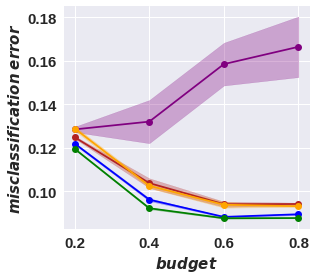

In [19]:
machine_types =  ['surrogate', 'surrogate_ova', 'score','confidence','Differentiable']
fig = plot_misclassification_loss(data_path,machine_types)